In [3]:
import pandas as pd
import numpy as np

In [2]:
# Read in data as pandas dataframe and display first 5 rows
original_features = pd.read_csv('/Users/nityanandwachche/Desktop/PASSNYC/temps.csv')
original_features = pd.get_dummies(original_features)

In [4]:
original_features.head()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [5]:
# Labels are the values we want to predict
original_value = np.array(original_features['actual'])

In [6]:
# Remove the labels from the features
# axis 1 refers to the columns
original_features= original_features.drop('actual', axis = 1)

In [7]:
# Saving feature names for later use
original_feature_list = list(original_features.columns)

In [8]:
# Convert to numpy array
original_features = np.array(original_features)

In [11]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [12]:
# Split the data into training and testing sets
original_train_features, original_test_features, original_train_value, original_test_value = train_test_split(original_features, original_value, test_size = 0.25, random_state = 42)

In [14]:
# The baseline predictions are the historical averages
baseline_preds = original_test_features[:, original_feature_list.index('average')]

In [23]:
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - original_test_value)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  5.06 degrees.


In [24]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [25]:
# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

In [27]:
# Train the model on training data
rf.fit(original_train_features, original_train_value);

In [28]:
# Use the forest's predict method on the test data
predictions = rf.predict(original_test_features)

In [29]:
# Calculate the absolute errors
errors = abs(predictions - original_test_value)

When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high. We are interested in how far away our average prediction is from the actual value so we take the absolute value (as we also did when establishing the baseline).

In [30]:
# Print out the mean absolute error (mae)
print('Average model error:', round(np.mean(errors), 2), 'degrees.')

Average model error: 3.87 degrees.


In [31]:
# Compare to baseline
improvement_baseline = 100 * abs(np.mean(errors) - np.mean(baseline_errors)) / np.mean(baseline_errors)
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')

Improvement over baseline: 23.5 %.


To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %.

In [33]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / original_test_value)

In [34]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.94 %.


In [38]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [39]:
# Pull out one tree from the forest
tree = rf.estimators_[5]

In [41]:
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = original_feature_list, rounded = True, precision = 1)

In [42]:
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

In [46]:
# Write graph to a png file
graph.write_png('tree.png')

FileNotFoundError: [Errno 2] "dot" not found in path.

In [49]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(original_train_features, original_train_value)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = original_feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

FileNotFoundError: [Errno 2] "dot" not found in path.

In [56]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(original_feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


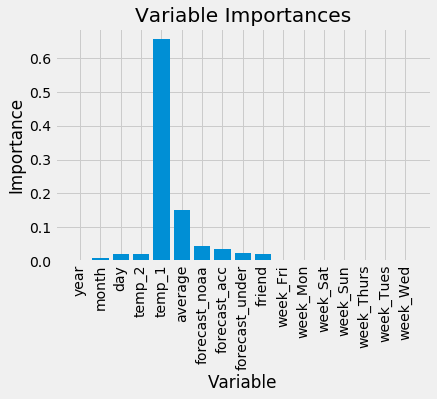

In [58]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, original_feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

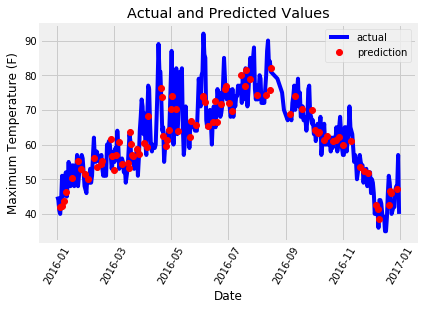

In [59]:
# Use datetime for creating date objects for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
# Dates of training values
months = original_features[:, original_feature_list.index('month')]
days = original_features[:, original_feature_list.index('day')]
years = original_features[:, original_feature_list.index('year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': original_value})
# Dates of predictions
months = original_test_features[:, original_feature_list.index('month')]
days = original_test_features[:, original_feature_list.index('day')]
years = original_test_features[:, original_feature_list.index('year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

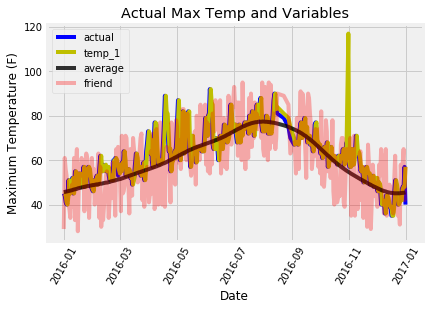

In [61]:
# Make the data accessible for plotting
true_data['temp_1'] = original_features[:, original_feature_list.index('temp_1')]
true_data['average'] = original_features[:, original_feature_list.index('average')]
true_data['friend'] = original_features[:, original_feature_list.index('friend')]
# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)
# Formatting plot
plt.legend(); plt.xticks(rotation = '60');
# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');